# Packages

In [59]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import pyvis
import igraph as i
import matplotlib.pyplot as plt
from collections import Counter
import string
from tqdm import tqdm
import re
from cdlib import algorithms
from concurrent.futures import ThreadPoolExecutor
import powerlaw
import pickle
import math

In [60]:
df_articles = pd.read_csv('_raw/articles_scraped.csv')

In [61]:
def prepare_df_connections(iterable):
    value_combinations = list(itertools.combinations(iterable, 2))
    df_connections = pd.DataFrame(value_combinations, columns=['entity_1','entity_2'])
    df_connections['weight'] = 0
    df_connections.reset_index(drop=True, inplace=True)

    return df_connections

In [62]:
def network_preparation(df_connections,dict_sizes): # df_connections is a dataframe of weighted edges
    elist = list(zip(df_connections['entity_1'],df_connections['entity_2'],df_connections['weight']))
    g = nx.Graph()
    g.add_weighted_edges_from([(el[0],el[1],el[2]) for el in elist if el[2]!=0])

    nt = pyvis.network.Network('1500px','1500px', bgcolor="#222222", font_color="white") #,select_menu=True,filter_menu=True)
    nt.barnes_hut()
    nt.from_nx(g) 
    nt.toggle_physics(True)

    for node in nt.nodes:
        node['font']['size'] = 100
        node['shape'] = 'circularImage'
        node['image'] = f"/Users/federico.bindi/Desktop/GitHub/organized-crime-articles/_aux/pictures/{node['id']}.png"
        node['size'] = dict_sizes[node['id']]

    return g,nt

# Individuals

## Preparation

In [63]:
df_individuals = pd.read_csv('_raw/individuals.csv')
df_individuals.loc[df_individuals.name.str.contains('Escand'),'search_term'] = 'Leyva Escandon'

In [64]:
dict_individuals = dict(zip(df_individuals.name,df_individuals.search_term))

In [65]:
dict_sizes = {}
for name in df_individuals.name.values:
    dict_sizes[name] = 0
    for article in df_articles.text.values:
        if dict_individuals[name] in article:
            dict_sizes[name] += 1

In [66]:
df_connections = prepare_df_connections(df_individuals.name.values)

Theoretically, we can analyse articles from 4 points of view:
1. Keyword extraction
2. Co-occurrence analysis (how many times two bosses' names appear close in an article)
3. Sentiment analysis on the articles

Points 2 and 3 are probably not useful: two bosses will appear closely in an article also if they are rival, and the articles are very likely to receive a negative sentiment classification anyway.

In [67]:
# Alliance Keywords with Regex Variations
alliance_keywords = [
    r"alliance", r"partner(s|ship|ing)?", r"cooperation", r"collaboration",
    r"joint venture", r"mutual support", r"united front", r"solidarity",
    r"work(ing)? together", r"coalition", r"team(ing)? up", r"combine(d)? forces",
    r"coordinated effort", r"combined operations", r"coordinated strategy",
    r"harmonious relationship", r"allied forces", r"mutual assistance"
]

# Rivalry Keywords with Regex Variations
rivalry_keywords = [
    r"rivalry", r"conflict", r"competition", r"feud", r"hostility", r"animosity",
    r"contention", r"dispute", r"antagonism", r"clash", r"enmity",
    r"competition for territory", r"power struggle", r"bitter rivalry",
    r"ongoing feud", r"turf war", r"opposing forces",
    r"confrontational relationship", r"longstanding dispute",
    r"battle for supremacy"
]

In [68]:
def count_words_in_text(keyword_list, text):
    
    counter = 0
    target_words = text.split()

    for keyword in keyword_list:
        matches = [1 if re.search(keyword,word) is not None else 0 for word in target_words]
        counter += sum(matches)
    
    return counter

In [69]:
def clean_text(text):
    # Create a translation table that maps punctuation characters to None
    translator = str.maketrans(string.punctuation, " " * len(string.punctuation))
    
    # Use the translate method to remove punctuation
    cleaned_text = text.lower().translate(translator)
    
    return cleaned_text

In [70]:
def detect_relationship(text, entity_1, entity_2):

    if entity_1 in text and entity_2 in text:

        alliance_score = count_words_in_text(alliance_keywords,clean_text(text))
        rivalry_score = count_words_in_text(rivalry_keywords,clean_text(text))

        if alliance_score > rivalry_score:
            return 1
        else:
            return 0
        
    else:
        return 0

In [71]:
'''for article in tqdm(df_articles.text.values):
    for row in range(len(df_connections)):

        entity_1 = dict_individuals[df_connections.loc[row,'entity_1']]
        entity_2 = dict_individuals[df_connections.loc[row,'entity_2']]

        df_connections.loc[row,'weight'] += detect_relationship(article, entity_1, entity_2)

df_connections.to_csv('_aux/Connections between individuals - alliances.csv')'''

"for article in tqdm(df_articles.text.values):\n    for row in range(len(df_connections)):\n\n        entity_1 = dict_individuals[df_connections.loc[row,'entity_1']]\n        entity_2 = dict_individuals[df_connections.loc[row,'entity_2']]\n\n        df_connections.loc[row,'weight'] += detect_relationship(article, entity_1, entity_2)\n\ndf_connections.to_csv('_aux/Connections between individuals - alliances.csv')"

In [72]:
df_connections = pd.read_csv('_aux/Connections between individuals - alliances.csv')
g, nt = network_preparation(df_connections,dict_sizes)
nt.show('_out/networks/individuals_alliances.html',notebook=False)

_out/networks/individuals_alliances.html


In [73]:
with open("_out/networks/individuals_alliances.pkl", "wb") as f:
    pickle.dump(g, f)

## Community detection (Louvain algorithm)

In [74]:
partition = algorithms.louvain(g, resolution=1., randomize=False)
print(partition.communities) # identified clustering

colors = ['#0000FF','#008000','#800080','#FF0000','#F0F8FF','#FF7F50','#B22222','#FF69B4','	#FFFACD']

for community,color_code in zip(partition.communities,colors):   
    for node in nt.nodes:
        if node['id'] in community:
            node['color'] = color_code

[['Ariel Máximo Cantero', 'Jobanis de Jesús Ávila Villadiego', 'Pablo Escobar', 'Diego Fernando Murillo Bejarano', 'Dairo Antonio Úsuga', 'Juan de Dios Úsuga', 'Daniel Barrera Barrera', 'Luis Agustin Caicedo Velandia', 'Martin Farfan Diaz Gonzalez', 'Victor Navarro', 'Walid Makled', 'Angel de Jesus Pacheco Chanci', 'Pedro Oliverio Guerrero Castillo', 'Diego Perez Henao', 'Luis Enrique Calle Serna', 'Javier Antonio Calle Serna', 'José Bayron Piedrahita Ceballos', 'Óscar Mauricio Pachón', 'Roberto Vargas Gutiérrez', 'Henry de Jesús López Londoño', 'Maximiliano Bonilla Orozco', 'Samark López Bello', 'Jose Eberto Lopez Montero', 'Marcos de Jesus Figueroa Garcia'], ['Genaro García Luna', 'Dámaso López Núñez', 'Joaquín Guzmán Loera', 'Ismael Zambada García', 'Hector Manuel Beltran Leyva', "Alejandro 'Omar' Treviño Morales", 'Jorge Eduardo Costilla Sánchez', 'Antonio Cardenas Guillen', 'Miguel Angel Treviño Morales', 'Nemesio Rubén Oseguera Cervantes', 'Reynerio Flores Lazo', 'José Natividad 

## Preferential attachment mechanism

It would make sense to think that criminals prefer to form connections with other criminals that already have lots of connections (because they can offer more power and connections). This would be reflected in the degree distribution following a power law.

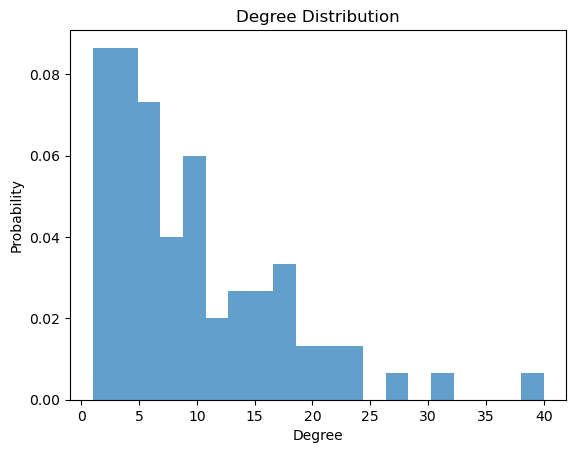

Calculating best minimal value for power law fit


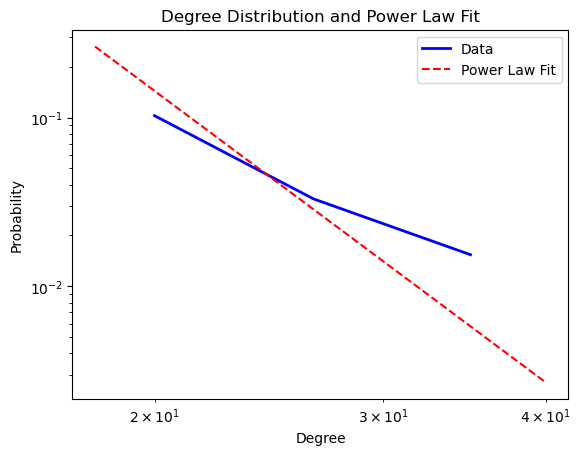

Power Law Fit Summary:
5.741186112500491
18.0
KS p-value: 0.10767576269572943


In [75]:
degree_sequence = [degree for node, degree in g.degree()]

plt.hist(degree_sequence, bins=20, density=True, alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution")
plt.savefig('_out/Individuals degree distribution.png')
plt.show()

fit = powerlaw.Fit(degree_sequence)

fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=plt.gca())
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution and Power Law Fit")
plt.legend(['Data', 'Power Law Fit'])
plt.savefig('_out/Individuals power law fit of degree distribution.png')
plt.show()

print("Power Law Fit Summary:")
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print("KS p-value:", fit.power_law.KS())
#print("Likelihood ratio p-value:", fit.power_law.distribution_compare('power_law', 'lognormal'))

## Validation

The first rows of the connections df are all corroborated by web search.

In [76]:
#df_connections = pd.read_csv('_aux/Connections between individuals - alliances.csv')
df_connections.sort_values('weight',ascending=False).head(30)

,Unnamed: 0,entity_1,entity_2,weight
3811,3811,Joaquín Guzmán Loera,Ismael Zambada García,41
3812,3812,Joaquín Guzmán Loera,Hector Manuel Beltran Leyva,23
3913,3913,Luis Enrique Calle Serna,Javier Antonio Calle Serna,22
3910,3910,Diego Perez Henao,Luis Enrique Calle Serna,16
635,635,Pablo Escobar,Diego Fernando Murillo Bejarano,15
3825,3825,Ismael Zambada García,Hector Manuel Beltran Leyva,14
3911,3911,Diego Perez Henao,Javier Antonio Calle Serna,14
580,580,Ariel Máximo Cantero,Joaquín Guzmán Loera,14
649,649,Pablo Escobar,Dairo Antonio Úsuga,12
3720,3720,Pedro Oliverio Guerrero Castillo,Daniel Barrera Barrera,12


# Groups

## Preparation

In [77]:
df_groups = pd.read_csv('_raw/groups.csv')

In [78]:
dict_groups = dict(zip(df_groups.name,df_groups.search_term))

In [79]:
dict_sizes2 = {}
for name in df_groups.name.values:
    dict_sizes2[name] = 0
    for article in df_articles.text.values:
        if dict_groups[name] in article:
            dict_sizes2[name] += 1

dict_sizes2 = {key:math.log(value) if value != 0 else 0 for key,value in dict_sizes2.items()}

In [80]:
df_connections2 = prepare_df_connections(df_groups.name.values)

In [81]:
def detect_relationship2(text, entity_1, entity_2):

    positions_1 = [i for i in range(len(text)) if text.startswith(entity_1, i)] # Proximity search
    positions_2 = [i for i in range(len(text)) if text.startswith(entity_2, i)]

    proximity_counter = 0
    for position_1 in positions_1:
        for position_2 in positions_2:
            if abs(position_1-position_2) <= 60: # the average word length in English is 5 characters (+ 1 blank space)
                proximity_counter += 1

    if entity_1 in text and entity_2 in text and proximity_counter >= 3:

        alliance_score = count_words_in_text(alliance_keywords,clean_text(text))
        rivalry_score = count_words_in_text(rivalry_keywords,clean_text(text))

        if alliance_score > rivalry_score:
            return 1
        else:
            return 0
        
    else:
        return 0

In [82]:
'''for article in tqdm(df_articles.text.values):
    for row in range(len(df_connections2)):
        0
        entity_1 = dict_groups[df_connections2.loc[row,'entity_1']]
        entity_2 = dict_groups[df_connections2.loc[row,'entity_2']]

        df_connections2.loc[row,'weight'] += detect_relationship2(article, entity_1, entity_2)

df_connections2.to_csv('_aux/Connections between groups - alliances.csv')'''

"for article in tqdm(df_articles.text.values):\n    for row in range(len(df_connections2)):\n        0\n        entity_1 = dict_groups[df_connections2.loc[row,'entity_1']]\n        entity_2 = dict_groups[df_connections2.loc[row,'entity_2']]\n\n        df_connections2.loc[row,'weight'] += detect_relationship2(article, entity_1, entity_2)\n\ndf_connections2.to_csv('_aux/Connections between groups - alliances.csv')"

In [83]:
g2, nt2 = network_preparation(df_connections2,dict_sizes2)
nt2.show('_out/networks/groups_alliances.html',notebook=False)

_out/networks/groups_alliances.html


In [84]:
with open("_out/networks/groups_alliances.pkl", "wb") as f:
    pickle.dump(g2, f)

## Community detection

In [85]:
'''partition2 = algorithms.louvain(g2, resolution=1., randomize=False)
print(partition2.communities) # identified clustering

colors = ['#0000FF','#008000','#800080','#FF0000','#F0F8FF','#FF7F50','#B22222','#FF69B4','	#FFFACD']

for community,color_code in zip(partition2.communities,colors):   
    for node in nt2.nodes:
        if node['id'] in community:
            node['color'] = color_code'''

"partition2 = algorithms.louvain(g2, resolution=1., randomize=False)\nprint(partition2.communities) # identified clustering\n\ncolors = ['#0000FF','#008000','#800080','#FF0000','#F0F8FF','#FF7F50','#B22222','#FF69B4','\t#FFFACD']\n\nfor community,color_code in zip(partition2.communities,colors):   \n    for node in nt2.nodes:\n        if node['id'] in community:\n            node['color'] = color_code"

## Preferential attachment

In [86]:
'''degree_sequence = [degree for node, degree in g2.degree()]

plt.hist(degree_sequence, bins=20, density=True, alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution")
plt.show()

fit = powerlaw.Fit(degree_sequence)

fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=plt.gca())
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution and Power Law Fit")
plt.legend(['Data', 'Power Law Fit'])
plt.show()

print("Power Law Fit Summary:")
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print("KS p-value:", fit.power_law.KS())'''

'degree_sequence = [degree for node, degree in g2.degree()]\n\nplt.hist(degree_sequence, bins=20, density=True, alpha=0.7)\nplt.xlabel("Degree")\nplt.ylabel("Probability")\nplt.title("Degree Distribution")\nplt.show()\n\nfit = powerlaw.Fit(degree_sequence)\n\nfit.plot_pdf(color=\'b\', linewidth=2)\nfit.power_law.plot_pdf(color=\'r\', linestyle=\'--\', ax=plt.gca())\nplt.xlabel("Degree")\nplt.ylabel("Probability")\nplt.title("Degree Distribution and Power Law Fit")\nplt.legend([\'Data\', \'Power Law Fit\'])\nplt.show()\n\nprint("Power Law Fit Summary:")\nprint(fit.power_law.alpha)\nprint(fit.power_law.xmin)\nprint("KS p-value:", fit.power_law.KS())'

## Validation

1. ELN and FARC have a longstanding rivalry.
2. MS13 and Barrio 18... Don't even get me started.
3. The Zetas and the Cartel del Golfo had a war starting in 2010.
4. FARC and ERPAC were rivals.
5. ELN and Rastrojos had clashes.

In [87]:
'''df_connections2.sort_values('weight',ascending=False).head(30)'''

"df_connections2.sort_values('weight',ascending=False).head(30)"